In [36]:
import numpy as np
from recordtype import recordtype

import pofah.jet_sample as js
import pofah.util.sample_factory as sf
import pofah.util.experiment as ex
import pofah.path_constants.sample_dict_file_parts_reco as sdfr
import pofah.path_constants.sample_dict_file_parts_selected as sdfs
import dadrah.selection.loss_strategy as lost
import dadrah.util.data_processing as dapr
import pofah.phase_space.cut_constants as cuts

In [37]:
#****************************************#
#       fitted polynomial selections
#****************************************#

cut_polys_par3 = {
    
    0.99 : np.poly1d([-7.03032980e-11, 1.06542864e-06, -2.17139299e-03, 3.31447885e+00]),
    0.9 : np.poly1d([-4.60568395e-11, 7.63471757e-07, -1.55537204e-03, 2.81116723e+00]),
    0.1 : np.poly1d([-1.57031061e-11, 3.01628110e-07, -5.03564141e-04, 1.83966064e+00])
}

cut_polys_par5 = {
    
    0.99 : np.poly1d([6.39477740e-18, -1.32096520e-13, 9.60377076e-10, -2.68629790e-06, 4.11271170e-03, -5.10765776e-01]),
    0.9 : np.poly1d([4.53587326e-18, -9.43590874e-14, 6.95373175e-10, -1.95383392e-06, 3.02479614e-03, 8.16766148e-03]),
    0.1 : np.poly1d([1.43916815e-18, -3.34572370e-14, 2.74613208e-10, -8.59156457e-07, 1.60246515e-03, 4.73345295e-01])
}

def fitted_selection(sample, strategy_id, quantile, params_n=5):
    loss_strategy = lost.loss_strategy_dict[strategy_id]
    loss = loss_strategy(sample)
    loss_cut = cut_polys_par5[quantile] if params_n == 5 else cut_polys_par3[quantile]
    return loss > loss_cut(sample['mJJ'])



In [38]:
#****************************************#
#           run parameters
#****************************************#

# signals
resonance = 'na'
signals = ['GtoWW15'+resonance+'Reco', 'GtoWW25'+resonance+'Reco', 'GtoWW35'+resonance+'Reco', 'GtoWW45'+resonance+'Reco']
masses = [1500, 2500, 3500, 4500]
xsec = 0.
quantiles = [0.1, 0.9, 0.99]



Parameters = recordtype('Parameters','run_n, qcd_sample_id, qcd_ext_sample_id, qcd_train_sample_id, qcd_test_sample_id, sig_sample_id, strategy_id, read_n')
params = Parameters(run_n=113, 
                    qcd_sample_id='qcdSigReco', 
                    qcd_ext_sample_id='qcdSigExtReco',
                    qcd_train_sample_id='qcdSigAllTrainReco', 
                    qcd_test_sample_id='qcdSigAllTestReco',
                    sig_sample_id=None, # set sig id later in loop
                    strategy_id='rk5_05',
                    read_n=None)


In [39]:
#****************************************#
#           read in data
#****************************************#

paths = sf.SamplePathDirFactory(sdfr.path_dict).update_base_path({'$run$': 'run_'+str(params.run_n)})

In [40]:
sample_id = 'qcdSigAllTestReco'

# 5-param fit

In [41]:
params_n = 5
sample = js.JetSample.from_input_dir(sample_id, paths.sample_dir_path(sample_id), **cuts.signalregion_cuts)

[DataReader] read_jet_features_from_dir(): reading all events from /eos/user/k/kiwoznia/data/VAE_results/events/run_113/qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_signalregion_parts
7671759 events read in 1 files in dir /eos/user/k/kiwoznia/data/VAE_results/events/run_113/qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_signalregion_parts


/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


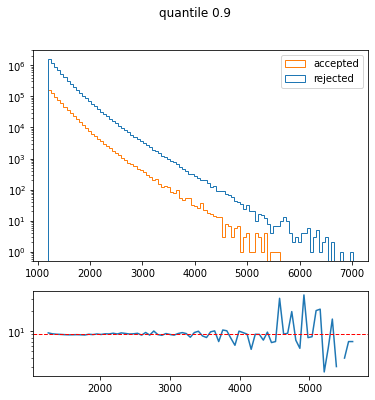

/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


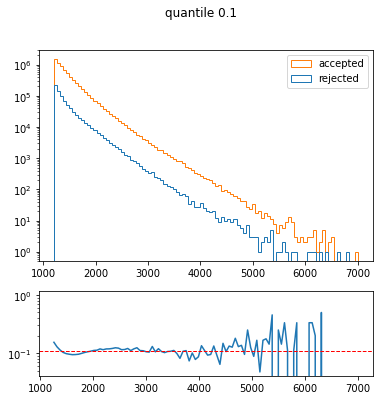

/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


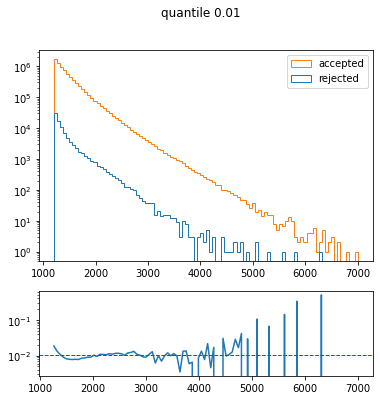

In [42]:
for quantile in quantiles:

    # using inverted quantile because of dijet fit code
    inv_quant = round((1.-quantile),2)

    #print('predicting {}'.format(sample.name))
    selection = fitted_selection(sample, params.strategy_id, quantile, params_n)
    sample.add_feature('sel_q{:02}'.format(int(inv_quant*100)), selection)

    accepted = sample.accepted(inv_quant)
    rejected = sample.rejected(inv_quant)

    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6,6), gridspec_kw={'height_ratios': [5, 2]})
    ns, bins, _ = ax1.hist([accepted['mJJ'], rejected['mJJ']], bins=100, histtype='step')
    ax1.set_yscale('log')
    ax1.legend(['accepted', 'rejected'])
    ax2.plot(bins[1:], ns[0]/ns[1])
    ax2.set_yscale('log')
    ax2.axhline(y=(1.-quantile)/quantile, color='r', linestyle='--', linewidth=1.)
    plt.suptitle('quantile ' + str(inv_quant))
    plt.show()

# 3-param fit

In [43]:
params_n = 3
sample = js.JetSample.from_input_dir(sample_id, paths.sample_dir_path(sample_id), **cuts.signalregion_cuts)

[DataReader] read_jet_features_from_dir(): reading all events from /eos/user/k/kiwoznia/data/VAE_results/events/run_113/qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_signalregion_parts
7671759 events read in 1 files in dir /eos/user/k/kiwoznia/data/VAE_results/events/run_113/qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_signalregion_parts


/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


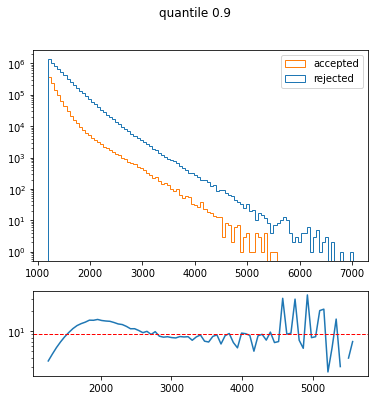

/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


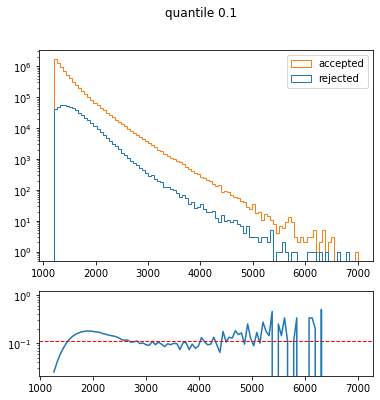

/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


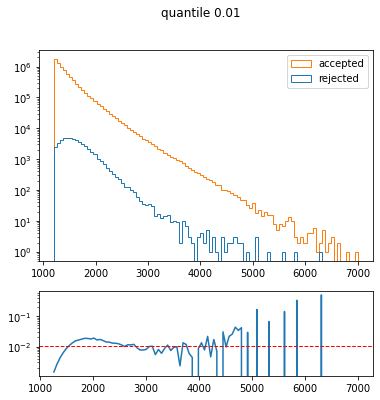

In [44]:
for quantile in quantiles:

    # using inverted quantile because of dijet fit code
    inv_quant = round((1.-quantile),2)

    #print('predicting {}'.format(sample.name))
    selection = fitted_selection(sample, params.strategy_id, quantile, params_n)
    sample.add_feature('sel_q{:02}'.format(int(inv_quant*100)), selection)

    accepted = sample.accepted(inv_quant)
    rejected = sample.rejected(inv_quant)

    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6,6), gridspec_kw={'height_ratios': [5, 2]})
    ns, bins, _ = ax1.hist([accepted['mJJ'], rejected['mJJ']], bins=100, histtype='step')
    ax1.set_yscale('log')
    ax1.legend(['accepted', 'rejected'])
    ax2.plot(bins[1:], ns[0]/ns[1])
    ax2.set_yscale('log')
    ax2.axhline(y=(1.-quantile)/quantile, color='r', linestyle='--', linewidth=1.)
    plt.suptitle('quantile ' + str(inv_quant))
    plt.show()

In [45]:
param_dict = {'$sig_name$': sample_id, '$sig_xsec$': str(int(xsec)), '$loss_strat$': params.strategy_id}
experiment = ex.Experiment(run_n=params.run_n, param_dict=param_dict).setup(model_dir_qr=True, analysis_dir_qr=True)
result_paths = sf.SamplePathDirFactory(sdfs.path_dict).update_base_path({'$run$': str(params.run_n), **param_dict}) # in selection paths new format with run_x, sig_x, ...
result_paths = result_paths.extend_base_path('fitted_cut', 'param5')

In [46]:
result_paths.base_dir

'/eos/user/k/kiwoznia/data/QR_results/events/run_113/sig_qcdSigAllTestReco/xsec_0/loss_rk5_05/fitted_cut/param5'

In [16]:
result_paths.sample_file_path(sample_id)

'/eos/user/k/kiwoznia/data/QR_results/events/run_113/sig_qcdSigAllTestReco/xsec_0/loss_rk5_05/fitted_cut/param5/qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_reco.h5'